## Test MHW

In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client
from mom6.mom6_module import mom6_io
from mom6.mom6_module import mom6_statistics
from mom6.mom6_module import mom6_mhw

In [2]:
### open local cluster
client = Client(processes=False)
print(client)
print(client.cluster.dashboard_link)

<Client: 'inproc://10.173.16.6/913837/1' processes=1 threads=64, memory=754.04 GiB>
http://10.173.16.6:8787/status


In [16]:
FORECAST = mom6_io.MOM6Forecast(
    var='tos',
    data_relative_dir='forecast/',
    static_relative_dir='static/',
    grid='raw',
    source='local')

In [17]:
ds_forecast = FORECAST.get_all()
ds_forecast = ds_forecast.rename({'geolon':'lon','geolat':'lat'})

In [18]:
# test ForecastClimatology Class generate_climo method
class_forecast_climo = mom6_statistics.ForecastClimatology(ds_forecast,'tos')
da_climo = class_forecast_climo.generate_climo(1993,1993,'compute')
da_climo.max().data

array(32.77348, dtype=float32)

In [6]:
# test ForecastClimatology Class generate_anom_batch method
dict_anom = class_forecast_climo.generate_anom_batch(1993,1993,1993,1993,'compute',precompute_climo=False)
dict_anom['anomaly'].max().data

array(9.948374, dtype=float32)

In [7]:
# test ForecastClimatology Class generate_anom_batch method with prescribed climo
dict_anom = class_forecast_climo.generate_anom_batch(1993,1993,1993,1993,'compute',precompute_climo=True,da_climo = da_climo)
dict_anom['anomaly'].max().data

array(10.367273, dtype=float32)

In [9]:
# test ForecastClimatology Class generate_anom_batch method with wrong prescribed climo should have ValueError
da_climo_error = da_climo.copy()
del da_climo_error.attrs['period_of_climatology']
dict_anom = class_forecast_climo.generate_anom_batch(1993,1993,1993,1993,'compute',precompute_climo=True,da_climo = da_climo_error)


ValueError: input climatology dataarray does not have attribute name "period_of_climatology" in the format of year "climo_start_year" to "climo_end_year"

In [10]:
# test ForecastClimatology Class generate_anom_batch method with wrong climo year
dict_anom = class_forecast_climo.generate_anom_batch(1994,1993,1993,1993,'compute',precompute_climo=False)


ValueError: The data array is empty based on the kwarg climo_start_year & climo_end_year

In [11]:
# test ForecastClimatology Class generate_anom_batch method with wrong anomaly year
dict_anom = class_forecast_climo.generate_anom_batch(1993,1994,1994,1993,'compute',precompute_climo=False)


ValueError: The data array is empty based on the kwarg anom_start_year & anom_end_year

In [12]:
# test ForecastClimatology Class generate_anom_batch method with wrong anomaly year
dict_anom = class_forecast_climo.generate_anom_batch(1993,1994,1991,1992,'compute',precompute_climo=False)

ValueError: The data array is empty based on the kwarg anom_start_year & anom_end_year

In [13]:
# test climo module empty array should have ValueError
class_forecast_climo = mom6_statistics.ForecastClimatology(ds_forecast,'tos')
da_climo = class_forecast_climo.generate_climo(1994,1993,'compute')

ValueError: The data array is empty based on the kwarg climo_start_year & climo_end_year

In [14]:
# test climo module empty array should have ValueError
class_forecast_climo = mom6_statistics.ForecastClimatology(ds_forecast,'tos')
da_climo = class_forecast_climo.generate_climo(1991,1992,'compute')

ValueError: The data array is empty based on the kwarg climo_start_year & climo_end_year

In [8]:
# test ForecastQuantile class generate_quantile method
dict_anom = class_forecast_climo.generate_anom_batch(1993,1993,1993,1993,'compute',precompute_climo=False)
ds_anom = xr.Dataset()
ds_anom['tos'] = dict_anom['anomaly']
ds_anom['climo'] = dict_anom['climatology']

In [10]:
# import importlib
# from mom6.mom6_module import mom6_statistics
# importlib.reload(mom6_statistics)

class_forecast_quantile = mom6_statistics.ForecastQuantile(ds_anom.sel(init='1993-03').isel(xh=slice(100,200),yh=slice(0, 100),lead=slice(0,1),member=slice(0,1)),'tos')
da_threshold = class_forecast_quantile.generate_quantile(1993,1993,90,False)
# da_threshold.sum().data
da_threshold.max().data

array(0.09486389, dtype=float32)

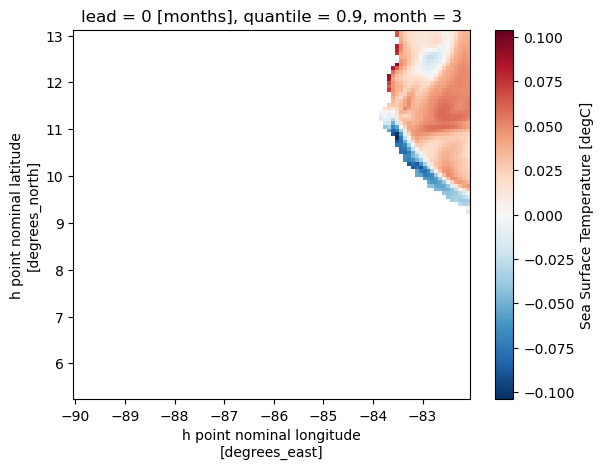

In [17]:
da_threshold.plot()

In [21]:
class_mhw = mom6_mhw.MarineHeatwaveForecast(ds_forecast.isel(xh=slice(100,200),yh=slice(0, 100),member=slice(0,1)),'tos')
ds_mhw_single = class_mhw.generate_forecast_single('2022-03',ds_anom['climo'].isel(xh=slice(100,200),yh=slice(0, 100)),da_threshold)
ds_mhw_single.mhw_prob90.sum().data



array(505., dtype=float32)

In [22]:
ds_mhw_single.ssta_avg.max().data


array(0.37654305, dtype=float32)

In [24]:
ds_mhw_single.mhw_mag_indentified_ens.max().data

array(0.37654305, dtype=float32)

In [39]:
class_mhw = mom6_mhw.MarineHeatwaveForecast(ds_forecast.isel(xh=slice(300,350),yh=slice(100, 150),lead=slice(0,1),member=slice(0,1)),'tos')
ds_mhw_batch = class_mhw.generate_forecast_batch(1993,1994,1993,1993,90)


In [41]:
ds_mhw_batch.tos_threshold90.max().data


array(0.37993317)

In [42]:
ds_mhw_batch.mhw_prob90.sum().data


array(6775., dtype=float32)

In [43]:
ds_mhw_batch.ssta_avg.max().data


array(0.47491646, dtype=float32)

In [45]:
ds_mhw_batch.mhw_magnitude_indentified_ens.max().compute().data

array(0.47491646, dtype=float32)

In [30]:
FORECAST_opendap = mom6_io.MOM6Forecast(
    var='tos',
    data_relative_dir='forecast/',
    static_relative_dir='static/',
    grid='raw',
    source='opendap')
ds_opendap = FORECAST_opendap.get_all()

In [33]:
# Keyerror in lon name
mom6_statistics.CoordinateWrangle(ds_opendap).check_coord_name()


KeyError: "Coordinates should have 'lon' with exact naming"

In [34]:
ds_opendap_latwrong = ds_opendap.rename({'geolon':'lon'})
# Keyerror in lat name
mom6_statistics.CoordinateWrangle(ds_opendap_latwrong).check_coord_name()

KeyError: "Coordinates should have 'lat' with exact naming"

In [39]:
mom6_statistics.CoordinateWrangle(ds_forecast).to_360().lon.min().data > 0

True